In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob as glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras import ops

2025-04-17 11:20:07.353317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

In [104]:
# Read in the shapefile for Maryland
shapefile_path = '/glade/derecho/scratch/dcalhoun/census/shapefiles/nhgis0001_shapefile_tl2023_us_tract_2023'
gdf = gpd.read_file(shapefile_path).to_crs('WGS84')
gdf = gdf[gdf['STATEFP'] == '24'][['GEOID', 'ALAND', 'INTPTLAT', 'INTPTLON', 'geometry']].reset_index(drop=True)
gdf.head()

GEOID        ALAND     INTPTLAT      INTPTLON  \
0  24001000100  486743629.0  +39.6365143  -078.5094487   
1  24001000200  124505957.0  +39.6123134  -078.7031037   
2  24001000500   11455399.0  +39.6546637  -078.7294891   
3  24001000600    4098568.0  +39.6409546  -078.7398353   
4  24001000700    1844978.0  +39.6329587  -078.7526552   

                                            geometry  
0  POLYGON ((-78.34283 39.72226, -78.34273 39.722...  
1  POLYGON ((-78.61336 39.53717, -78.61337 39.537...  
2  POLYGON ((-78.71741 39.63624, -78.71742 39.636...  
3  POLYGON ((-78.71741 39.63624, -78.71742 39.636...  
4  POLYGON ((-78.7384 39.62725, -78.73849 39.6271...

In [4]:
# Define encoding of day of year as a cyclical feature
def encode_day_of_year(x):
    return np.sin(2 * np.pi * x / 365.0)

In [5]:
agg_files = sorted(glob.glob('/glade/derecho/scratch/dcalhoun/aggregated/tract/Maryland/ifs/0.125/t2m/00/24/*/*/*.csv'))

In [6]:
dfs = []
for f in agg_files:
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['time'] = pd.to_datetime(df['time'])
df['dayofyear'] = encode_day_of_year(df['time'].dt.dayofyear)
df['GEOID'] = df['GEOID'].astype('str')
df.head()

GEOID       time  t2m_abs_error  dayofyear
0  24001000100 2016-01-03       1.337073    0.05162
1  24001000200 2016-01-03       1.441930    0.05162
2  24001000500 2016-01-03       1.464916    0.05162
3  24001000600 2016-01-03       1.464916    0.05162
4  24001000700 2016-01-03       1.464916    0.05162

In [7]:
df = df.merge(gdf, on='GEOID', how='left')
df.head()

GEOID       time  t2m_abs_error  dayofyear        ALAND     INTPTLAT  \
0  24001000100 2016-01-03       1.337073    0.05162  486743629.0  +39.6365143   
1  24001000200 2016-01-03       1.441930    0.05162  124505957.0  +39.6123134   
2  24001000500 2016-01-03       1.464916    0.05162   11455399.0  +39.6546637   
3  24001000600 2016-01-03       1.464916    0.05162    4098568.0  +39.6409546   
4  24001000700 2016-01-03       1.464916    0.05162    1844978.0  +39.6329587   

       INTPTLON  
0  -078.5094487  
1  -078.7031037  
2  -078.7294891  
3  -078.7398353  
4  -078.7526552

In [17]:
data = np.concatenate([
    df['t2m_abs_error'].values,
    df['dayofyear'].values,
    df['INTPTLAT'].astype('float').values,
    df['INTPTLON'].astype('float').values,
    df['ALAND'].values
]).reshape((5, len(df))).T.reshape(-1,1463*5)
print(data.shape)

(3170, 7315)


In [19]:
data[0,:]

array([ 1.33707259e+00,  5.16196672e-02,  3.96365143e+01, ...,
        3.92916116e+01, -7.66329627e+01,  5.76317000e+05])

In [20]:
# train-test split for day of year
data_train, data_test, _, _ = train_test_split(
    data,
    data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [21]:
print(data_train.shape, data_test.shape)

(2219, 7315) (951, 7315)


In [22]:
data_train[:10]

array([[ 1.33707259e+00,  5.16196672e-02,  3.96365143e+01, ...,
         3.92916116e+01, -7.66329627e+01,  5.76317000e+05],
       [ 1.26829318e+00,  6.88024268e-02,  3.96365143e+01, ...,
         3.92916116e+01, -7.66329627e+01,  5.76317000e+05],
       [ 8.26975029e-01,  8.59647987e-02,  3.96365143e+01, ...,
         3.92916116e+01, -7.66329627e+01,  5.76317000e+05],
       ...,
       [ 1.64164424e+00,  1.71293144e-01,  3.96365143e+01, ...,
         3.92916116e+01, -7.66329627e+01,  5.76317000e+05],
       [ 9.45252138e-01,  1.88226710e-01,  3.96365143e+01, ...,
         3.92916116e+01, -7.66329627e+01,  5.76317000e+05],
       [ 3.47139155e-01,  2.05104500e-01,  3.96365143e+01, ...,
         3.92916116e+01, -7.66329627e+01,  5.76317000e+05]])

In [23]:
# rescale error
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test)

In [24]:
data_train_scaled[:10]

array([[-2.57925298e-01,  2.37493380e-02, -2.48689958e-13, ...,
         1.10844667e-12,  7.10542736e-14,  0.00000000e+00],
       [-3.18348448e-01,  4.79819129e-02, -2.48689958e-13, ...,
         1.10844667e-12,  7.10542736e-14,  0.00000000e+00],
       [-7.06049231e-01,  7.21857354e-02, -2.48689958e-13, ...,
         1.10844667e-12,  7.10542736e-14,  0.00000000e+00],
       ...,
       [ 9.64281782e-03,  1.92522956e-01, -2.48689958e-13, ...,
         1.10844667e-12,  7.10542736e-14,  0.00000000e+00],
       [-6.02142043e-01,  2.16404096e-01, -2.48689958e-13, ...,
         1.10844667e-12,  7.10542736e-14,  0.00000000e+00],
       [-1.12758808e+00,  2.40206577e-01, -2.48689958e-13, ...,
         1.10844667e-12,  7.10542736e-14,  0.00000000e+00]])

# ANN Autoencoder
Features: 
1. Absolute error
2. Day of year cyclical feature
3. Latitude
4. Longitude
5. Area

In [8]:
keras.utils.set_random_seed(812)

NameError: name 'keras' is not defined

In [14]:
# create fully connected autoencoder
model = keras.Sequential(name='autoencoder')

# input
model.add(keras.Input(shape=(5,), name='input')) # features

# encoder
# hidden layers
model.add(layers.Dense(16, activation="tanh", name='encoder'))

# desired dimensions
model.add(layers.Dense(2, activation="linear", name='bottleneck'))

# decoder
model.add(layers.Dense(16, activation="tanh", name='decoder'))

# Finally, we add last layer
model.add(layers.Dense(5, activation='linear', name='output')) # back to the original shape

# print model summary
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Dense)                 │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263 (1.03 KB)

 Trainable params: 263 (1.03 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 1463
EPOCHS = 50

In [16]:
# train the NN now
history = model.fit(
    x=data_train_scaled,
    y=data_train_scaled,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5397 - mean_absolute_error: 0.4950 - mean_squared_error: 0.5397 - root_mean_squared_error: 0.7287 - val_loss: 0.2860 - val_mean_absolute_error: 0.3324 - val_mean_squared_error: 0.2860 - val_root_mean_squared_error: 0.5347
Epoch 2/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.3257 - mean_squared_error: 0.2626 - root_mean_squared_error: 0.5123 - val_loss: 0.2056 - val_mean_absolute_error: 0.3030 - val_mean_squared_error: 0.2056 - val_root_mean_squared_error: 0.4534
Epoch 3/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1968 - mean_absolute_error: 0.2949 - mean_squared_error: 0.1968 - root_mean_squared_error: 0.4436 - val_loss: 0.1777 - val_mean_absolute_error: 0.2857 - val_mean_squared_error: 0.1777 - val_root_mean_squared_error: 0.4216
Epoch 4/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1760 - mean_absolute_error: 0.2821 - mean_squared_error: 0.1760 - root_mean_sq

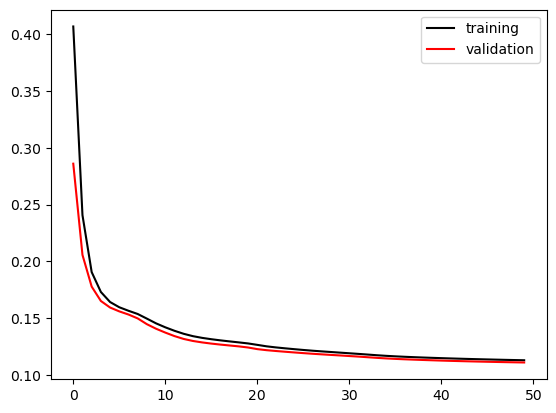

In [17]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [18]:
# evaluation mode
data_pred = model.predict(data_test_scaled)

43479/43479 ━━━━━━━━━━━━━━━━━━━━ 19s 426us/step


In [19]:
# check prediction shape matches test data shape
data_pred.shape

(1391313, 5)

In [20]:
data_test_scaled.shape

(1391313, 5)

In [21]:
data_pred_inv = scaler.inverse_transform(data_pred)

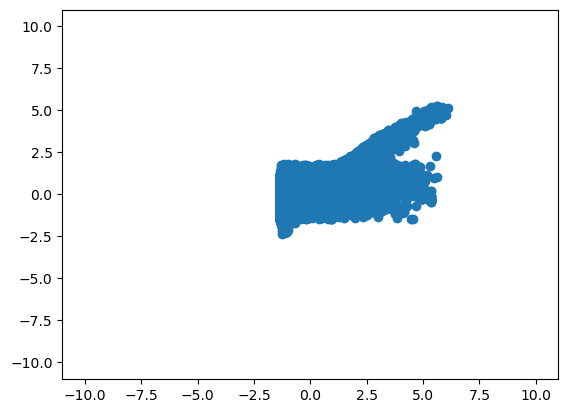

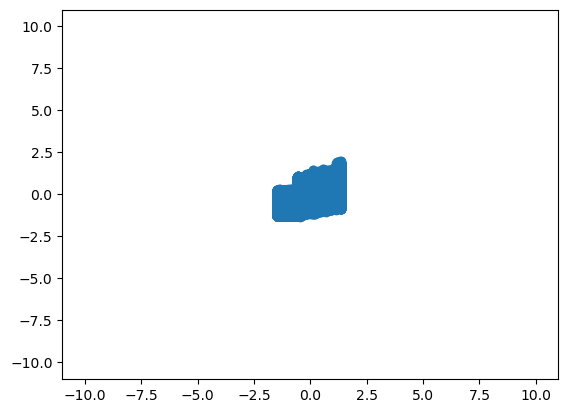

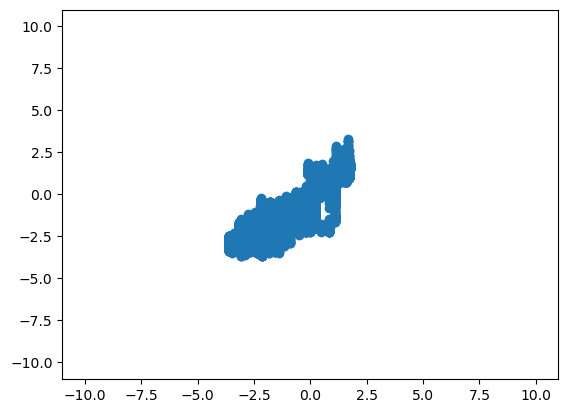

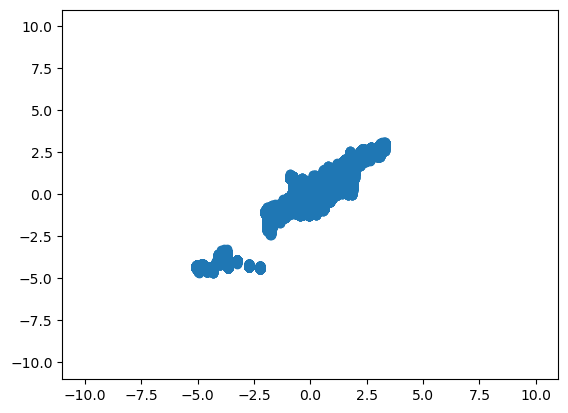

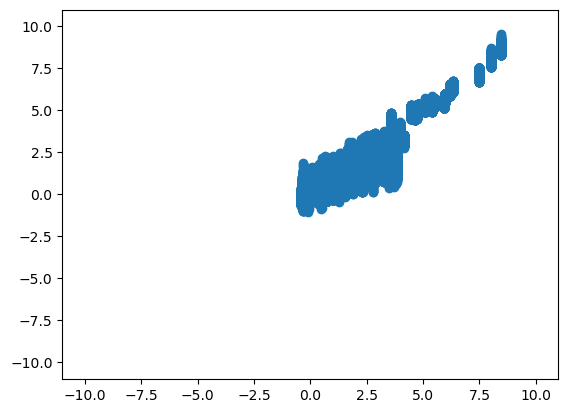

In [22]:
# visualize obs (x-axis) to nn predictions (y-axis)
for i in range(data_test_scaled.shape[1]):
    plt.scatter(data_test_scaled[:,i], data_pred[:,i])
    a = 11
    plt.xlim([-a,a])
    plt.ylim([-a,a])
    plt.show()

In [23]:
np.sqrt(1/len(data_test[:,0]) * np.sum((data_test[:,0] - data_pred_inv[:,0])**2))

0.33629193627241716

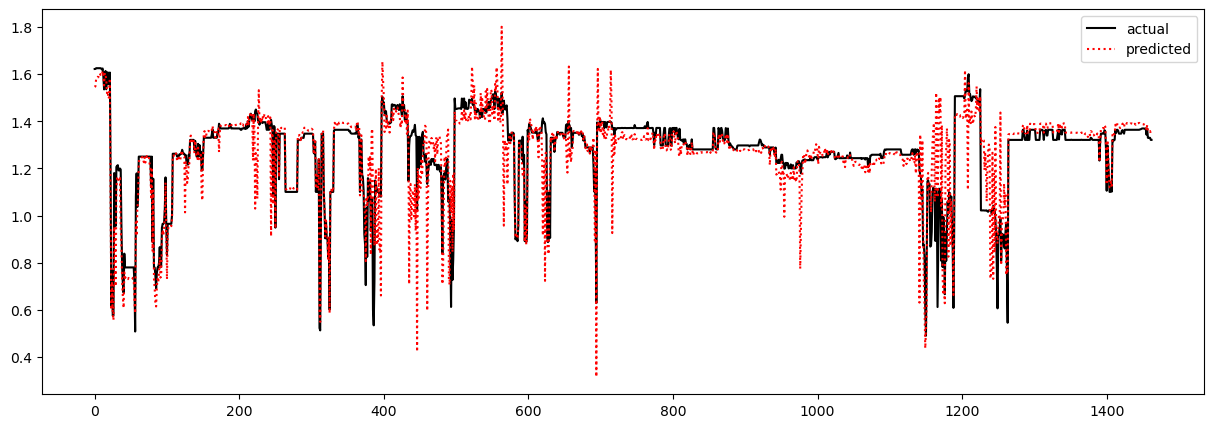

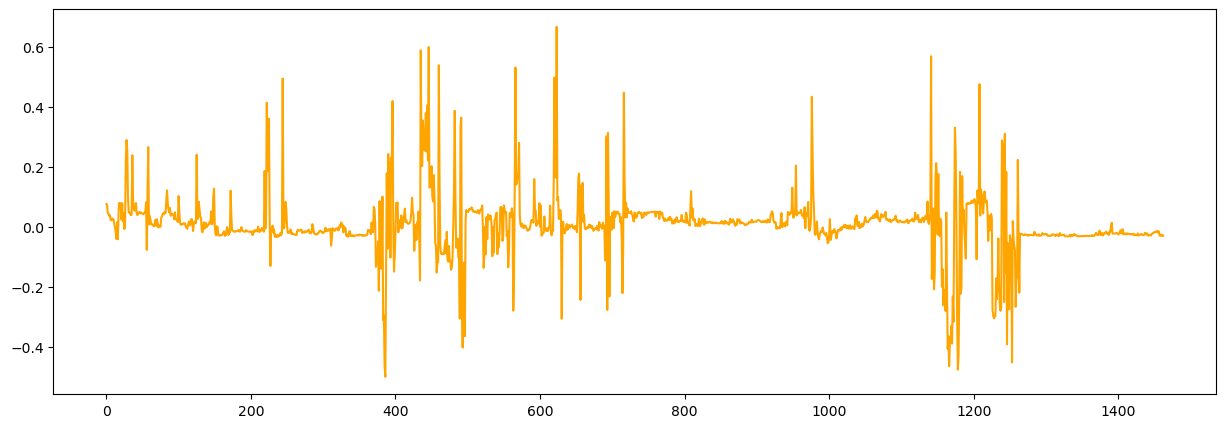

In [24]:
plt.subplots(figsize=(15,5))
plt.plot(data_test.reshape(-1,1463,5).T[0].mean(axis=1), c='k', label='actual')
plt.plot(data_pred_inv.reshape(-1,1463,5).T[0].mean(axis=1), c='r', label='predicted', linestyle=':')
plt.legend()
plt.show()

plt.subplots(figsize=(15,5))
plt.plot(data_test.reshape(-1,1463,5).T[0].mean(axis=1) - data_pred_inv.reshape(-1,1463,5).T[0].mean(axis=1), c='orange', label='difference')
plt.show()

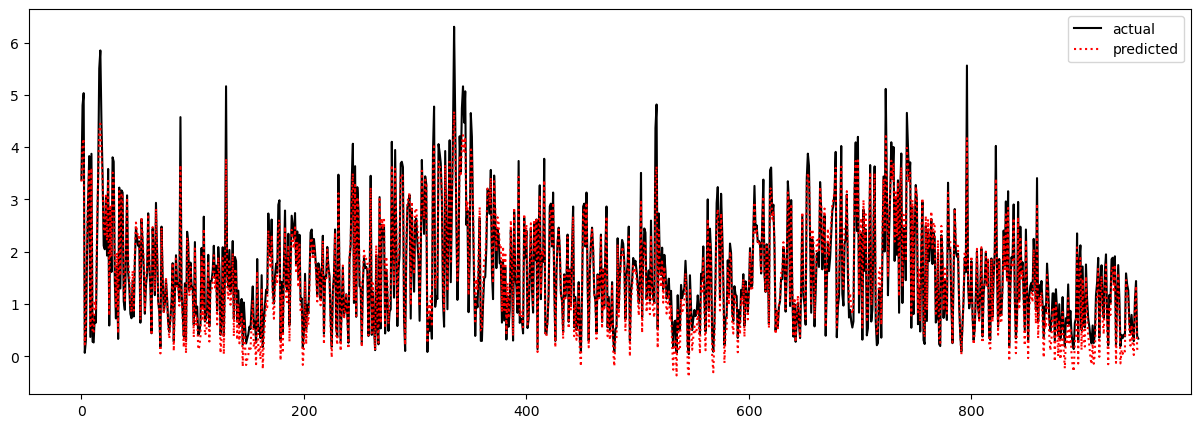

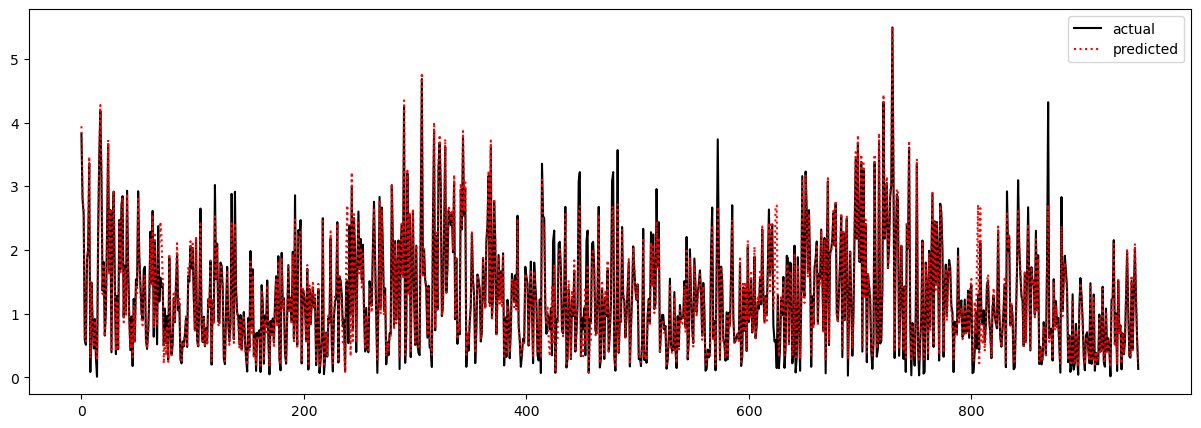

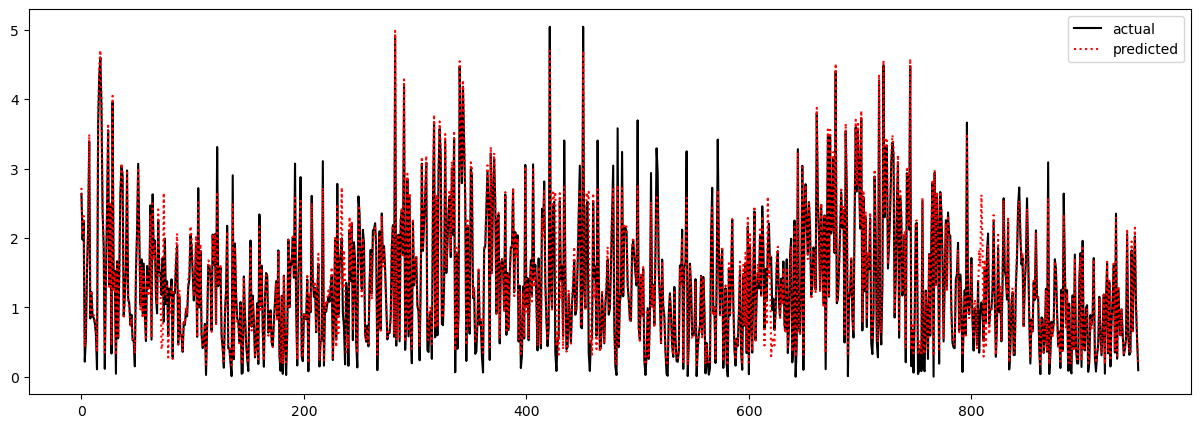

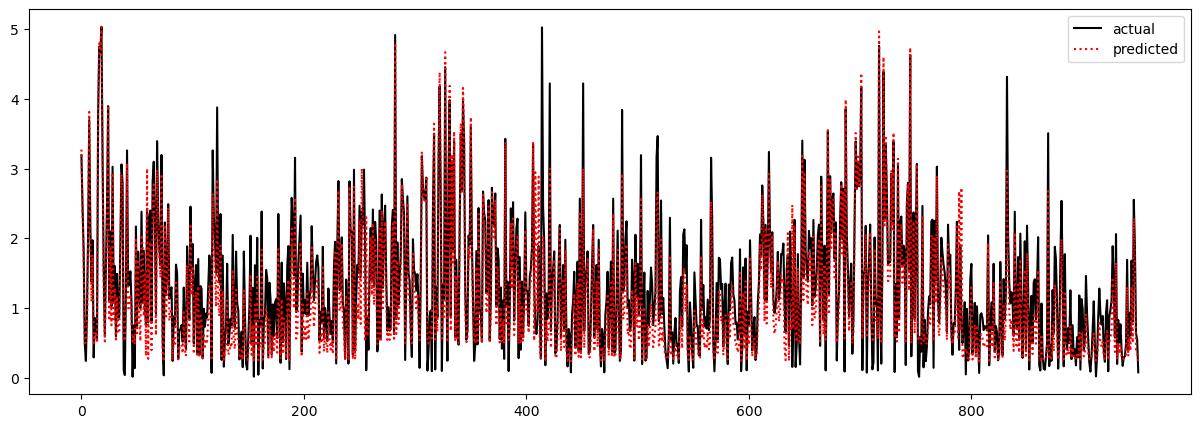

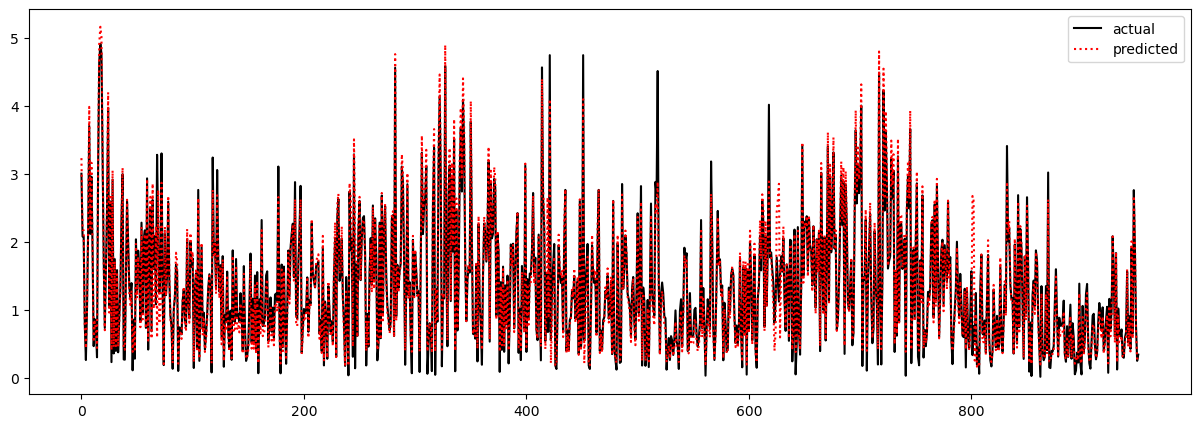

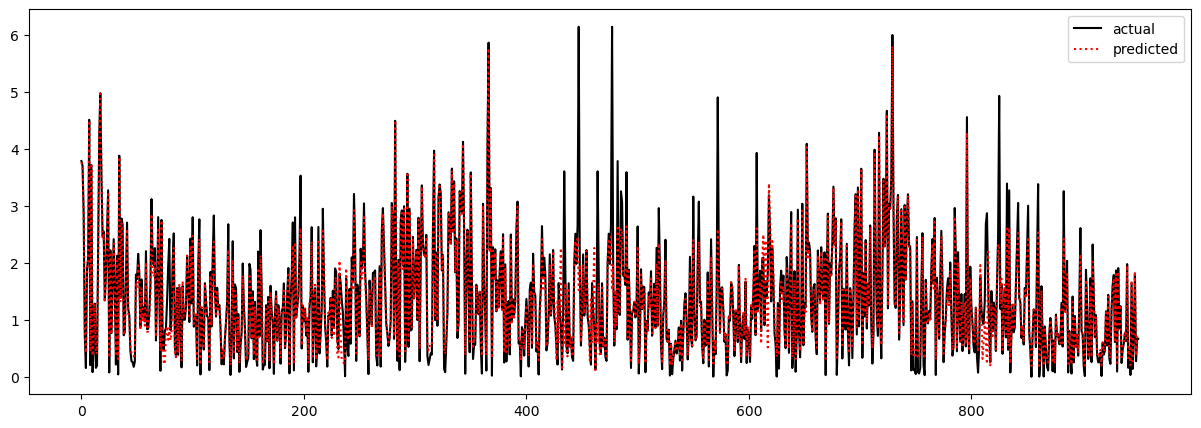

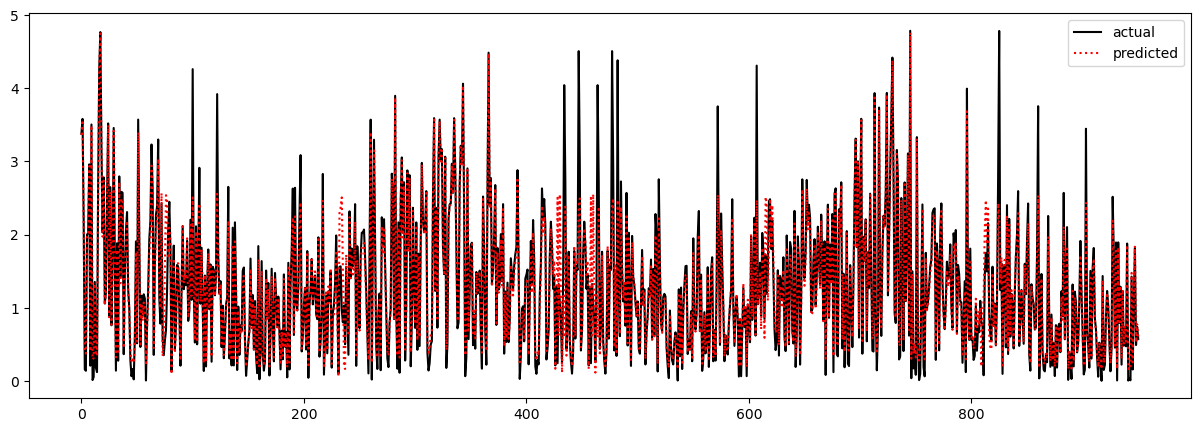

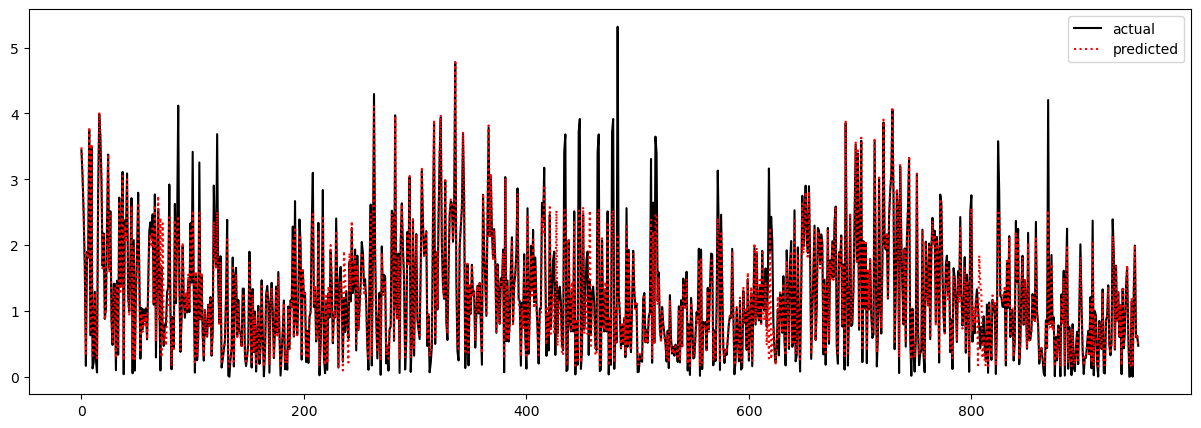

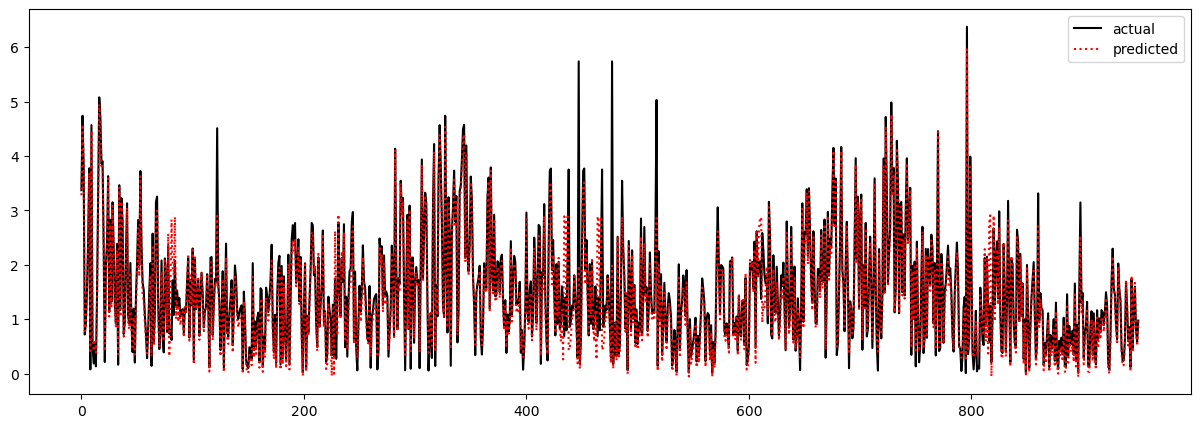

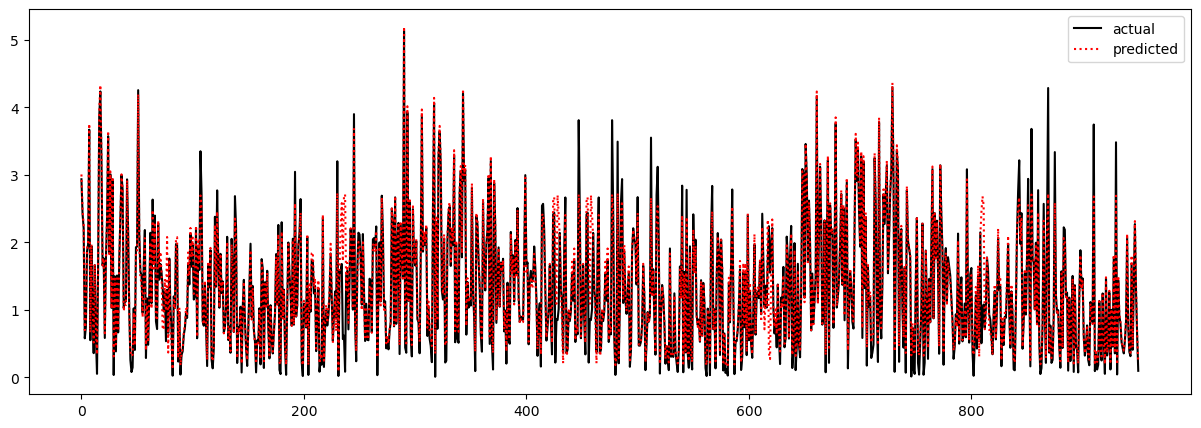

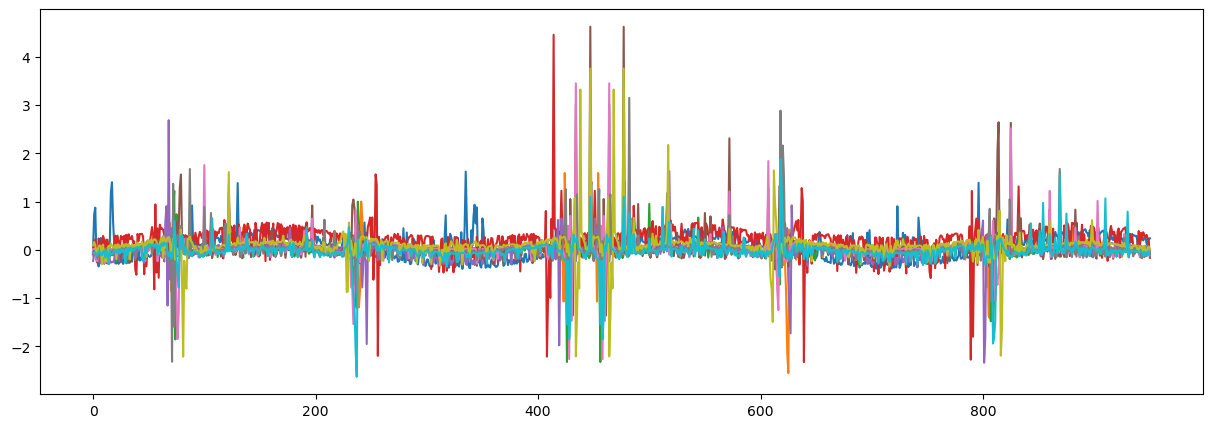

In [25]:
for i in range(0,1463, 150):
    plt.subplots(figsize=(15,5))
    plt.plot(data_test.reshape(-1,1463,5).T[0][i], c='k', label='actual')
    plt.plot(data_pred_inv.reshape(-1,1463,5).T[0][i], c='r', label='predicted', linestyle=':')
    plt.legend()
    plt.show()

plt.subplots(figsize=(15,5))
for i in range(0,1463, 150):
    plt.plot(data_test.reshape(-1,1463,5).T[0][i] - data_pred_inv.reshape(-1,1463,5).T[0][i], label='difference')
plt.show()

In [26]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[1].output
    )

In [27]:
# input test data into the bottleneck function
bottleneck_output = np.array(bottleneck(data_test_scaled))

In [28]:
bottleneck_output.shape

(1391313, 2)

In [29]:
bottleneck_output.shape

(1391313, 2)

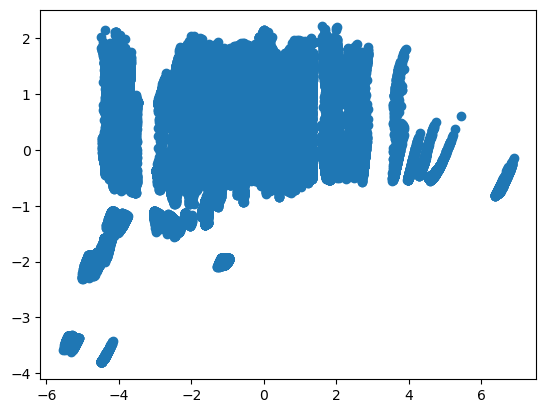

In [30]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()

# VAE

In [38]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [39]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(5*1463,), name='encoder_input')

x = layers.Dense(16, activation="tanh", name='encoder_hidden')(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling(name='sample')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 7315)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_hidden      │ (None, 16)        │    117,056 │ encoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sample (Sampling)   │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,124 (457.52 KB)

 Trainable params: 117,124 (457.52 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')

x = layers.Dense(16, activation="tanh", name='decoder_hidden')(latent_inputs)

decoder_outputs = layers.Dense(5*1463, activation="linear", name='decoder_output')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 7315)           │       124,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,403 (485.95 KB)

 Trainable params: 124,403 (485.95 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):

        super().__init__(**kwargs)

        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )

        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Encode the inputs
        z_mean, z_log_var, z = self.encoder(inputs)

        # Decode the latent representation
        reconstructed = self.decoder(z)

        return reconstructed

    def closs(self, data):
        z_mean, z_log_var, z = self.encoder(data)

        reconstruction = self.decoder(z)

        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.mean_squared_error(data, reconstruction),
            )
        )

        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))

        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return total_loss
    
    def train_step(self, data):

        with tf.GradientTape() as tape:
            total_loss = self.closs(data)
            
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):

        with tf.GradientTape() as tape:
            total_loss = self.closs(data)
            
        grads = tape.gradient(total_loss, self.trainable_weights)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [42]:
vae = VAE(encoder, decoder)

In [43]:
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    #loss=vae.closs
    )

In [44]:
history = vae.fit(
    x=data_train_scaled,
    batch_size=30,
    epochs=50,
    validation_split=0.1,
    shuffle=False
    )

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - kl_loss: 0.3965 - loss: 12.3937 - reconstruction_loss: 11.9972 - val_kl_loss: 0.0457 - val_loss: 11.4610 - val_reconstruction_loss: 11.4153
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 0.0459 - loss: 12.0169 - reconstruction_loss: 11.9710 - val_kl_loss: 0.0371 - val_loss: 11.4082 - val_reconstruction_loss: 11.3710
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0562 - loss: 11.9675 - reconstruction_loss: 11.9113 - val_kl_loss: 0.1481 - val_loss: 11.3215 - val_reconstruction_loss: 11.1734
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.2023 - loss: 11.7976 - reconstruction_loss: 11.5953 - val_kl_loss: 0.4485 - val_loss: 10.9924 - val_reconstruction_loss: 10.5438
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.4591 - loss: 11.2990 - reconstruction_loss: 10.8399 - val_kl_loss: 0.7529 - val_loss: 10.1539 - val_reconstruction_loss: 9.4010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 

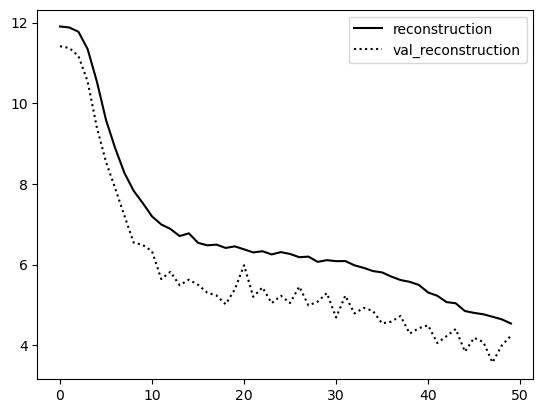

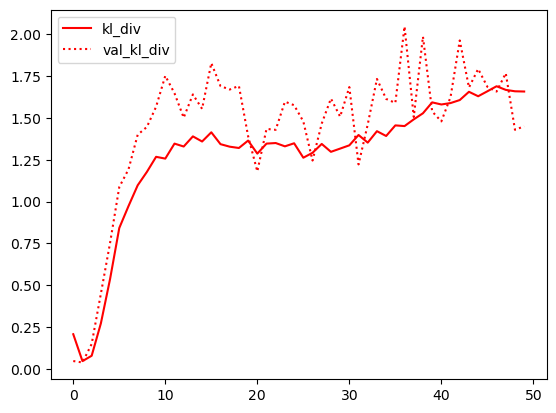

In [45]:
plt.plot(history.history["reconstruction_loss"], c='k', label='reconstruction')
plt.plot(history.history["val_reconstruction_loss"], c='k', linestyle=':', label='val_reconstruction')
plt.legend()
plt.show()

plt.plot(history.history["kl_loss"], c='r', label='kl_div')
plt.plot(history.history["val_kl_loss"], c='r', linestyle=':', label='val_kl_div')
plt.legend()
plt.show()

In [58]:
data_test.reshape(-1,1463,5)[:,:,0]

array([[3.37962251, 3.38015983, 3.52307355, ..., 3.1381059 , 2.93503462,
        2.93503462],
       [4.79977177, 4.51013564, 4.53654807, ..., 2.94220565, 2.42354656,
        2.42354656],
       [5.03376072, 4.49547184, 4.14611553, ..., 2.30442279, 2.20839608,
        2.20839608],
       ...,
       [1.43946619, 1.76605786, 1.87878517, ..., 1.11235749, 1.25924071,
        1.25924071],
       [0.38384375, 0.38814095, 0.37394804, ..., 0.67043398, 0.61767964,
        0.61767964],
       [0.33849518, 0.38227149, 0.42923709, ..., 0.13407326, 0.09634406,
        0.09634406]])

In [59]:
np.sqrt(1/len(data_test) * np.sum((data_test.reshape(-1,1463,5)[:,:,0] - scaler.inverse_transform(np.array(vae.call(data_test_scaled))).reshape(-1,1463,5)[:,:,0])**2))

27.30257233781276

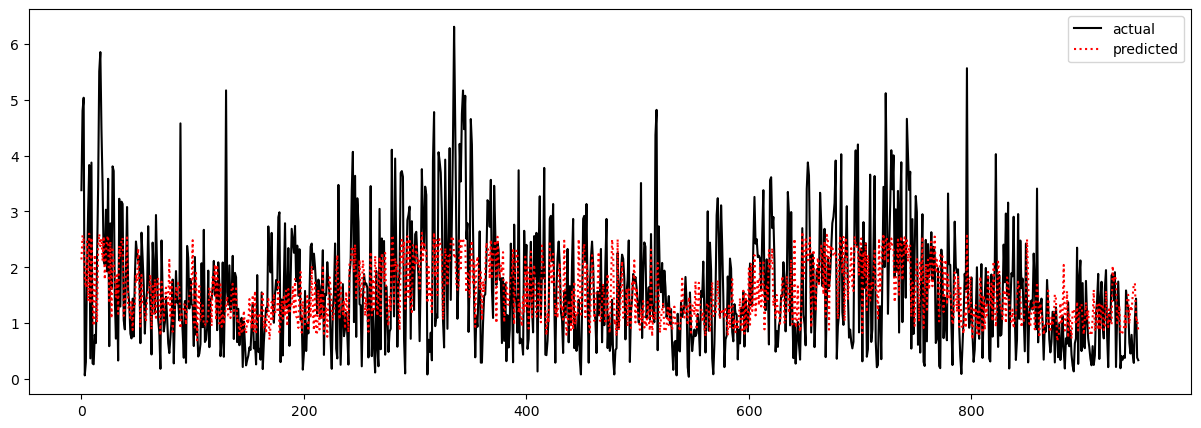

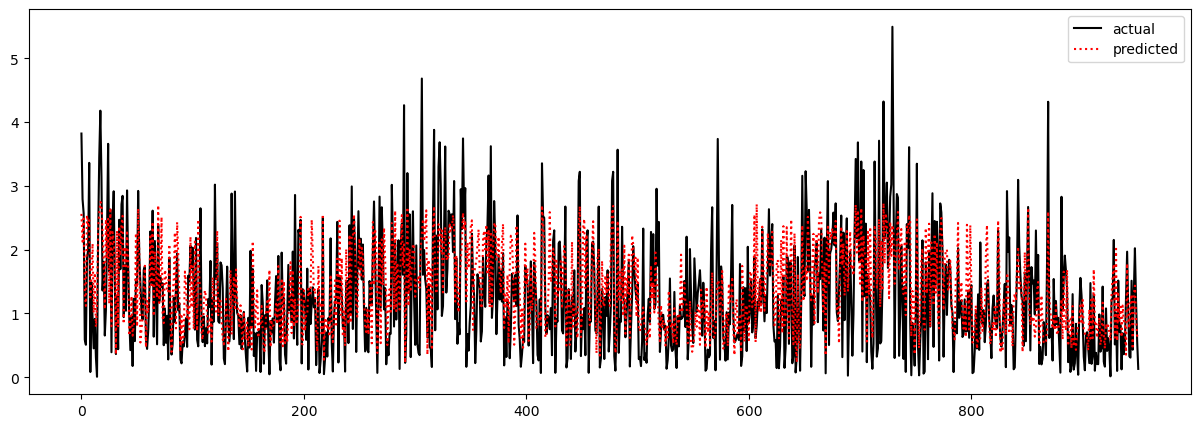

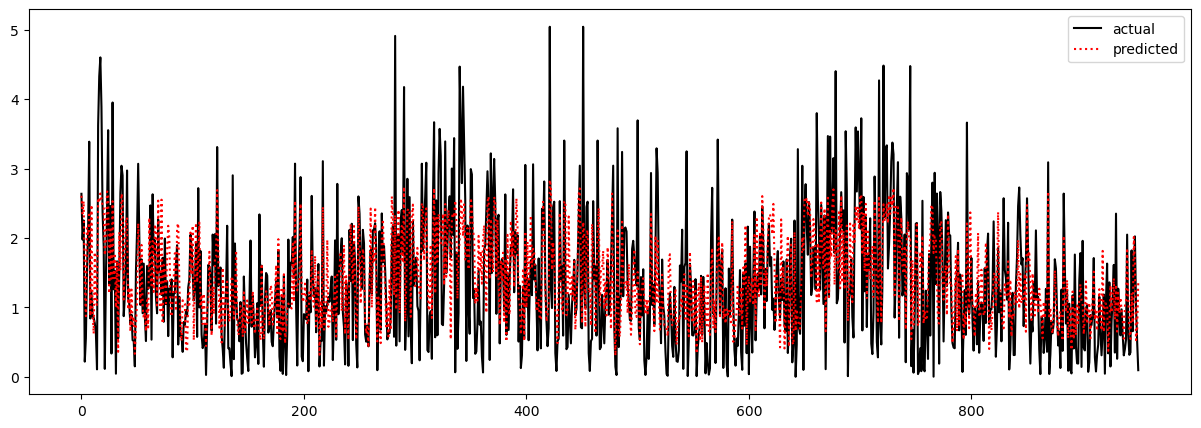

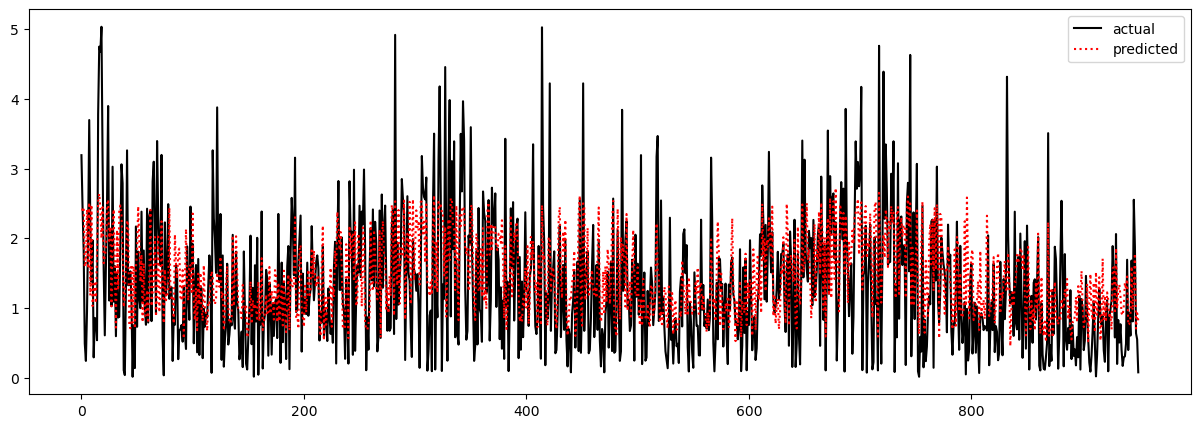

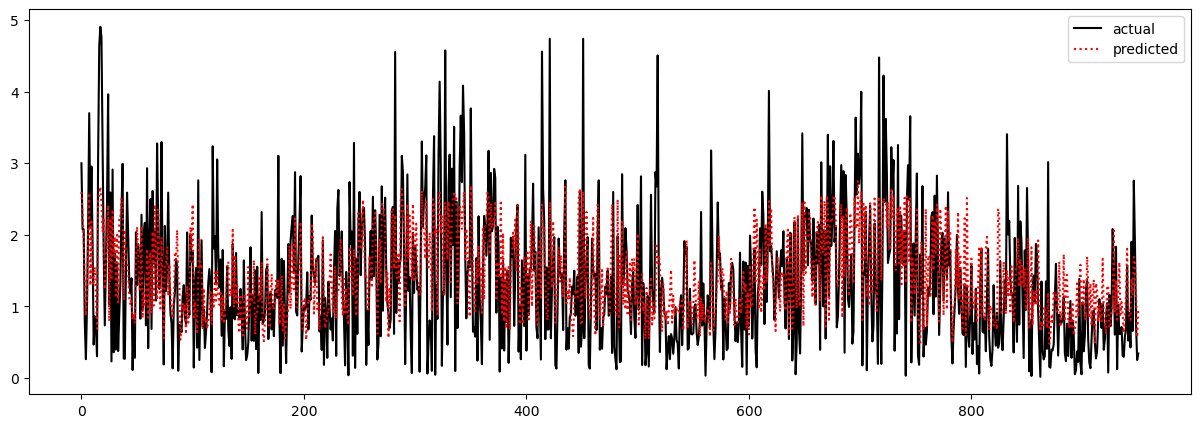

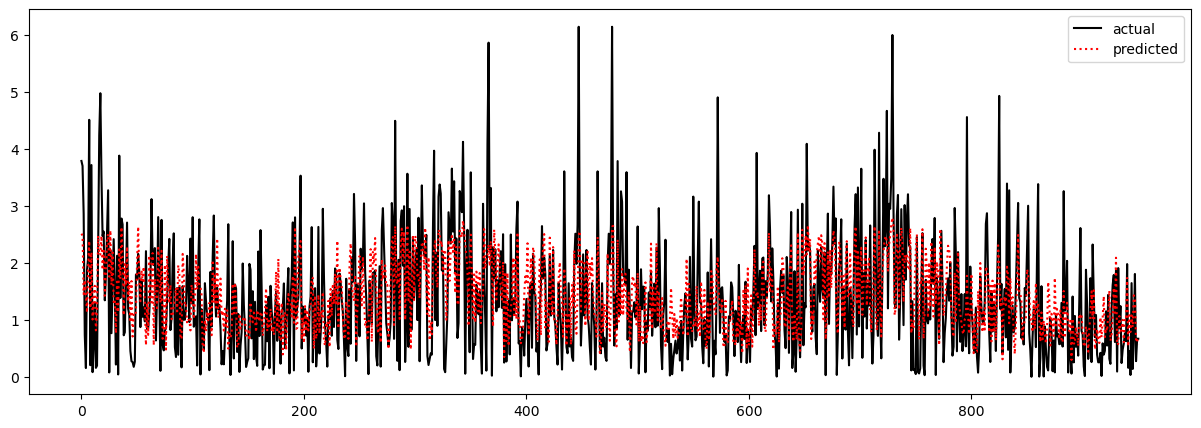

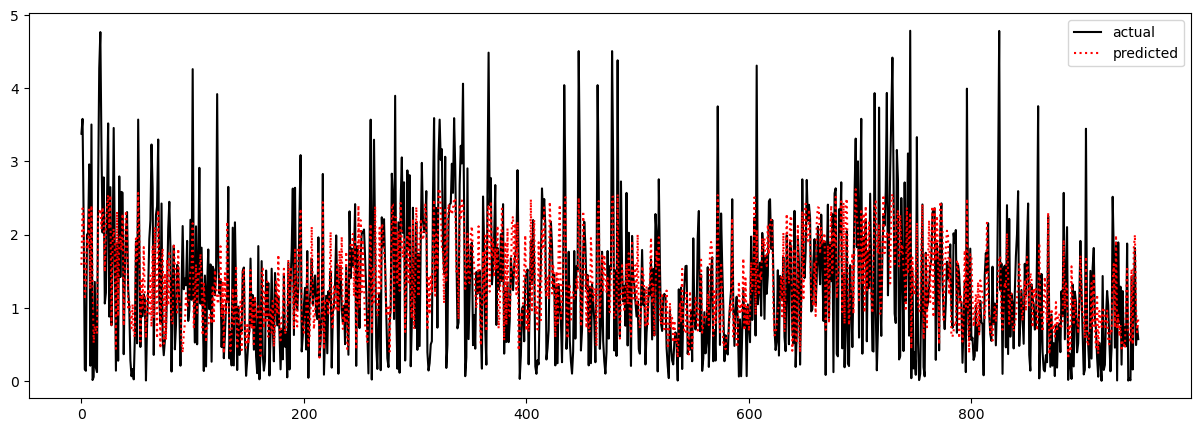

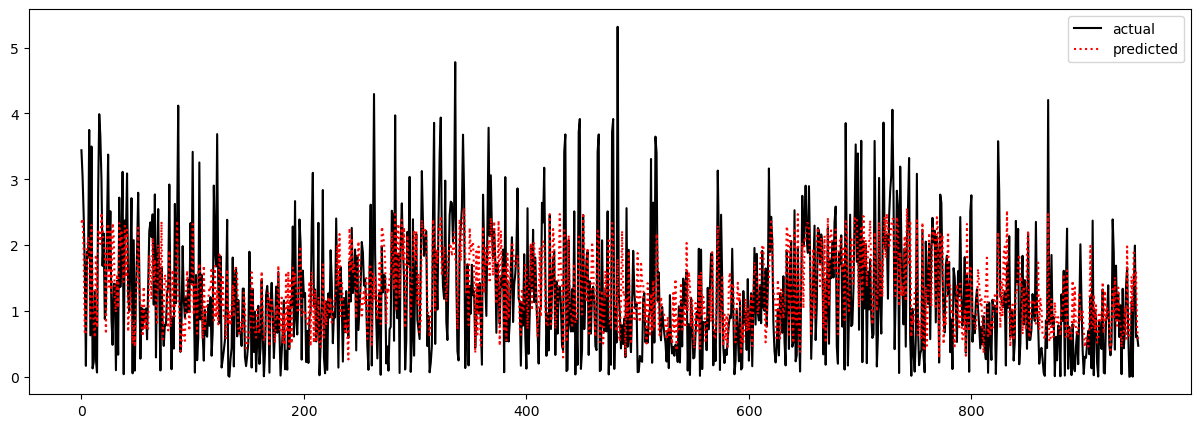

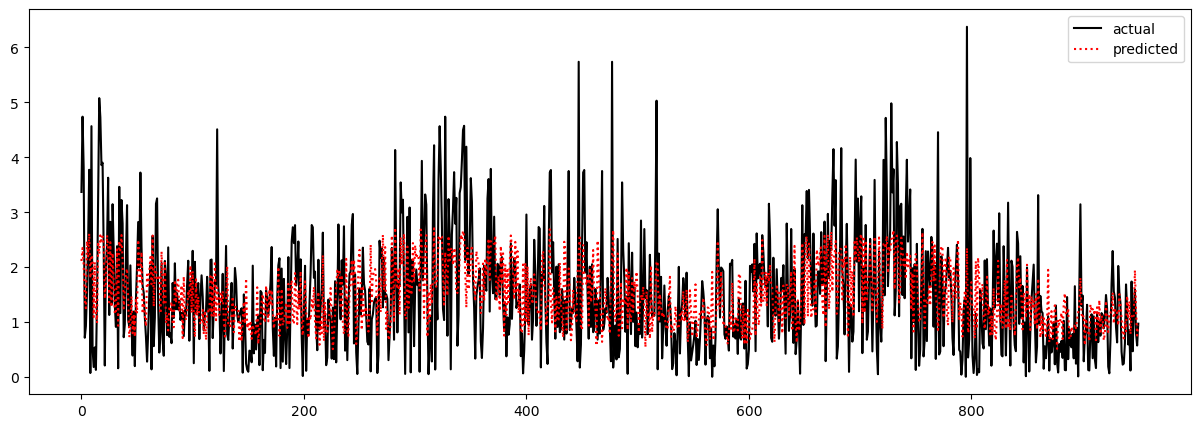

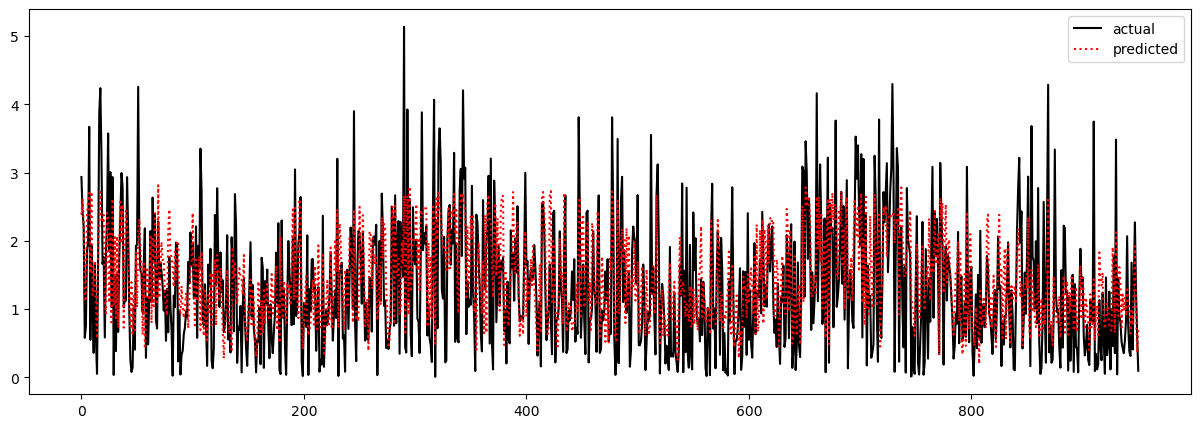

In [47]:
for i in range(0,1463, 150):
    plt.subplots(figsize=(15,5))
    plt.plot(data_test.reshape(-1,1463,5).T[0][i], c='k', label='actual')
    plt.plot(scaler.inverse_transform(np.array(vae.call(data_test_scaled))).reshape(-1,1463,5).T[0][i], c='r', label='predicted', linestyle=':')
    plt.legend()
    plt.show()

In [60]:
bottleneck = tf.keras.Model(
    inputs=vae.layers[0].input,
    outputs=vae.layers[0].output
    )

In [63]:
latent_space_mu = np.array(bottleneck(data_train_scaled)[0]).reshape(-1,2)
latent_space_logvar = np.array(bottleneck(data_train_scaled)[1]).reshape(-1,2)
latent_space_samples = np.array(bottleneck(data_train_scaled)[2]).reshape(-1,2)

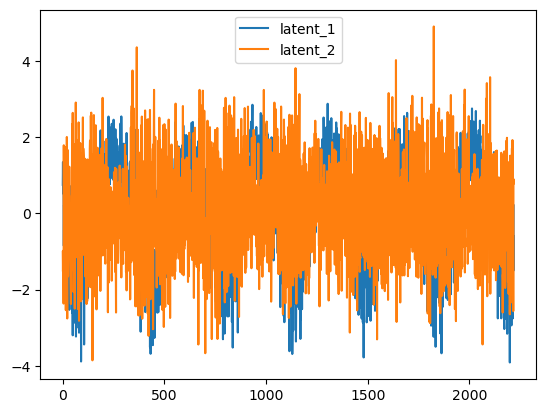

In [67]:
plt.plot(latent_space_samples[:,0], label='latent_1')
plt.plot(latent_space_samples[:,1], label='latent_2')
plt.legend()
plt.show()

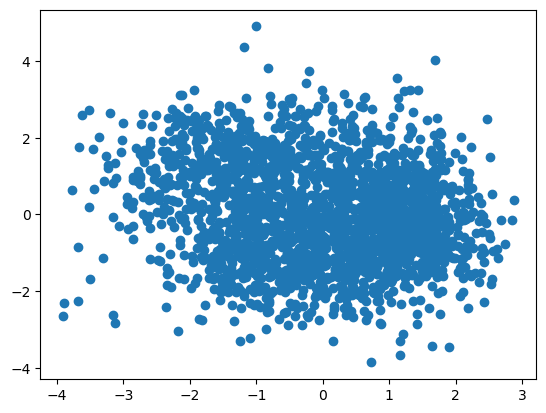

In [68]:
plt.scatter(latent_space_samples[:,0], latent_space_samples[:,1])
plt.show()

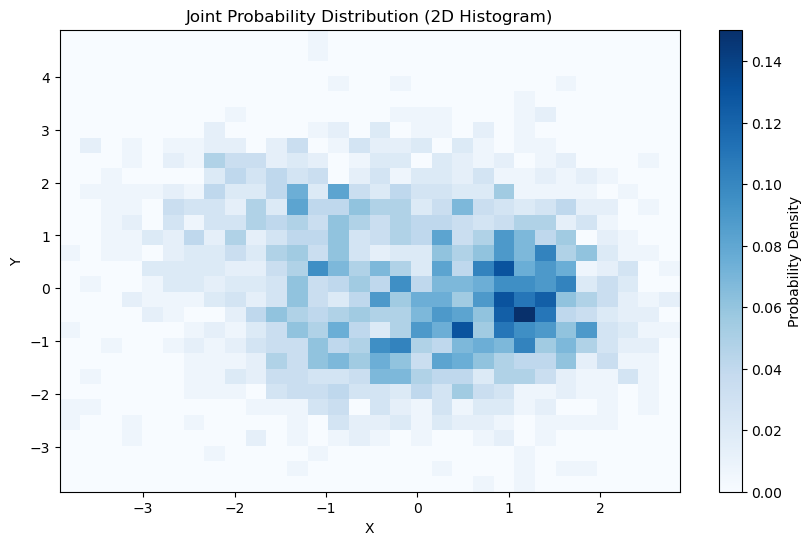

In [69]:
# Using a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(latent_space_samples[:, 0].flatten(), latent_space_samples[:, 1].flatten(), bins=30, density=True, cmap='Blues')
plt.colorbar(label='Probability Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint Probability Distribution (2D Histogram)')
plt.show()

In [70]:
latent_space_mu.mean(axis=0)

array([-0.03840942,  0.00923428], dtype=float32)

In [71]:
latent_space_logvar.mean(axis=0)

array([-1.0163486 , -0.45032576], dtype=float32)

In [72]:
np.exp(0.5*latent_space_logvar.mean(axis=0))

array([0.6015929 , 0.79838616], dtype=float32)

In [73]:
latent_space_samples.mean(axis=0)

array([-0.02212284,  0.02150886], dtype=float32)

In [74]:
latent_space_samples.std(axis=0)

array([1.2988088, 1.3102281], dtype=float32)

In [75]:
np.log(latent_space_samples.var(axis=0))

array([0.522895  , 0.54040253], dtype=float32)

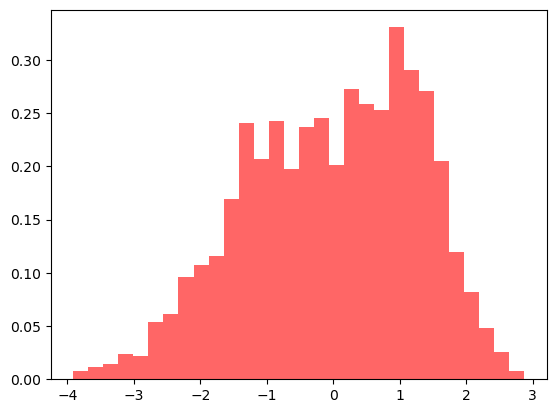

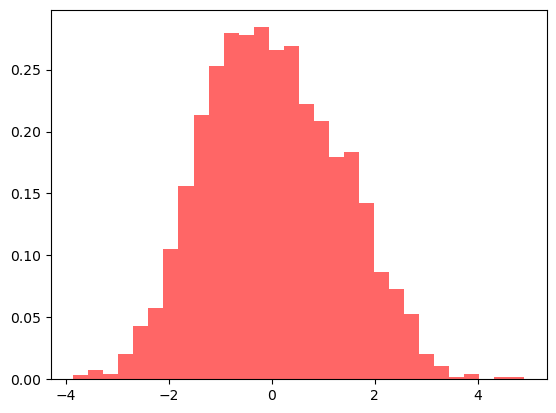

In [76]:
plt.hist(latent_space_samples[:, 0].flatten(), bins=30, density=True, alpha=0.6, color='r')
plt.show()

plt.hist(latent_space_samples[:, 1].flatten(), bins=30, density=True, alpha=0.6, color='r')
plt.show()

In [89]:
scaler.inverse_transform(np.array(vae.decoder(latent_space_samples[np.newaxis,0,:]))).reshape(1463, -1)[:,0]

array([1.0486248 , 1.0618635 , 1.074118  , ..., 0.7941369 , 0.79694587,
       0.7928763 ], dtype=float32)

In [90]:
scaler.inverse_transform(np.array(vae.decoder(np.array([-10, 2])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([2.6332695, 2.6236944, 2.6483638, ..., 2.658951 , 2.6366184,
       2.6294467], dtype=float32)

In [91]:
scaler.inverse_transform(np.array(vae.decoder(np.array([-10.01, 2.05])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([2.6333768, 2.6238186, 2.6484914, ..., 2.659115 , 2.6367702,
       2.6296055], dtype=float32)

In [92]:
scaler.inverse_transform(np.array(vae.decoder(np.array([2, -2])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([0.71677476, 0.73536783, 0.73896056, ..., 0.4224751 , 0.42730907,
       0.4294707 ], dtype=float32)

In [93]:
scaler.inverse_transform(np.array(vae.decoder(np.array([2.02, -1.982])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([0.7172857 , 0.7356591 , 0.73919874, ..., 0.4254371 , 0.4304339 ,
       0.43285146], dtype=float32)

In [94]:
scaler.inverse_transform(np.array(vae.decoder(np.array([-2, 10])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([2.7321773, 2.6849508, 2.711594 , ..., 3.0645833, 3.0822744,
       3.1276824], dtype=float32)

In [95]:
scaler.inverse_transform(np.array(vae.decoder(np.array([10, -2])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([0.65585935, 0.6666218 , 0.66708845, ..., 0.44319665, 0.45305827,
       0.46110526], dtype=float32)

In [96]:
scaler.inverse_transform(np.array(vae.decoder(np.array([-6, 6])[np.newaxis,:]))).reshape(1463, -1)[:,0]

array([2.6946042, 2.6760268, 2.7023222, ..., 2.7888198, 2.7679453,
       2.7532911], dtype=float32)

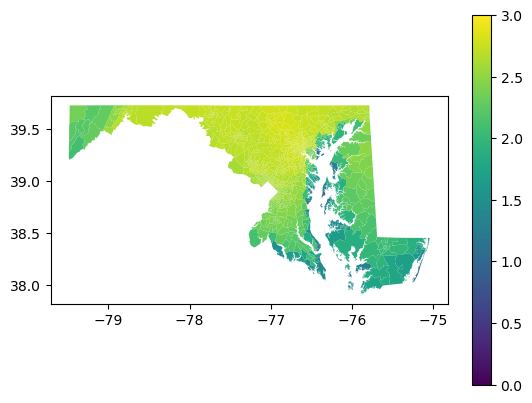

In [124]:
mydf = pd.DataFrame()
mydf['GEOID'] = gdf['GEOID']
mydf['geometry'] = gdf['geometry']
mydf['error'] = scaler.inverse_transform(np.array(vae.decoder(np.array([-6, 6])[np.newaxis,:]))).reshape(1463, -1)[:,0]
gen_gdf = gpd.GeoDataFrame(mydf)

gen_gdf.plot(column='error', legend=True, vmin=0, vmax=3)
plt.show()

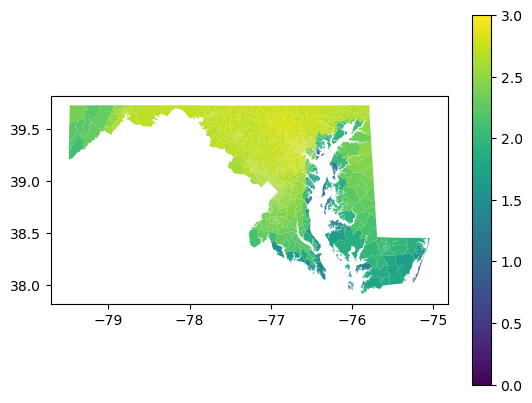

In [134]:
mydf = pd.DataFrame()
mydf['GEOID'] = gdf['GEOID']
mydf['geometry'] = gdf['geometry']
mydf['error'] = scaler.inverse_transform(np.array(vae.decoder(np.array([-6.05, 6.1])[np.newaxis,:]))).reshape(1463, -1)[:,0]
gen_gdf = gpd.GeoDataFrame(mydf)

gen_gdf.plot(column='error', legend=True, vmin=0, vmax=3)
plt.show()